# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from collections import deque
from dqn_agent import Agent
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `environment_path` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"Banana.app"`
- **Windows** (x86): `"Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
environment_path = "Banana.app"
```

In [2]:
environment_path = "Banana_Windows_x86_64/Banana.exe"

In [3]:
env = UnityEnvironment(file_name=environment_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print('Brain:', brain_name)

Brain: BananaBrain


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 4. DQN Function

In [6]:
TARGET_SCORE = 13.0

def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_mean = []                   # list the mean of the window scores
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):  
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
                
        scores.append(score)                       # save most recent score
        scores_window.append(score)                # save most recent score
        scores_mean.append(np.mean(scores_window)) # save mean score
        
        eps = max(eps_end, eps_decay*eps)   # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, scores_mean[-1]), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, scores_mean[-1]))
        
        if scores_mean[-1] >= TARGET_SCORE:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, scores_mean[-1]))
            break
            
    return scores, scores_mean

### 5. Train Agent

Running on: cuda:0
Episode 100	Average Score: 10.34
Episode 155	Average Score: 13.05
Environment solved in 55 episodes!	Average Score: 13.05


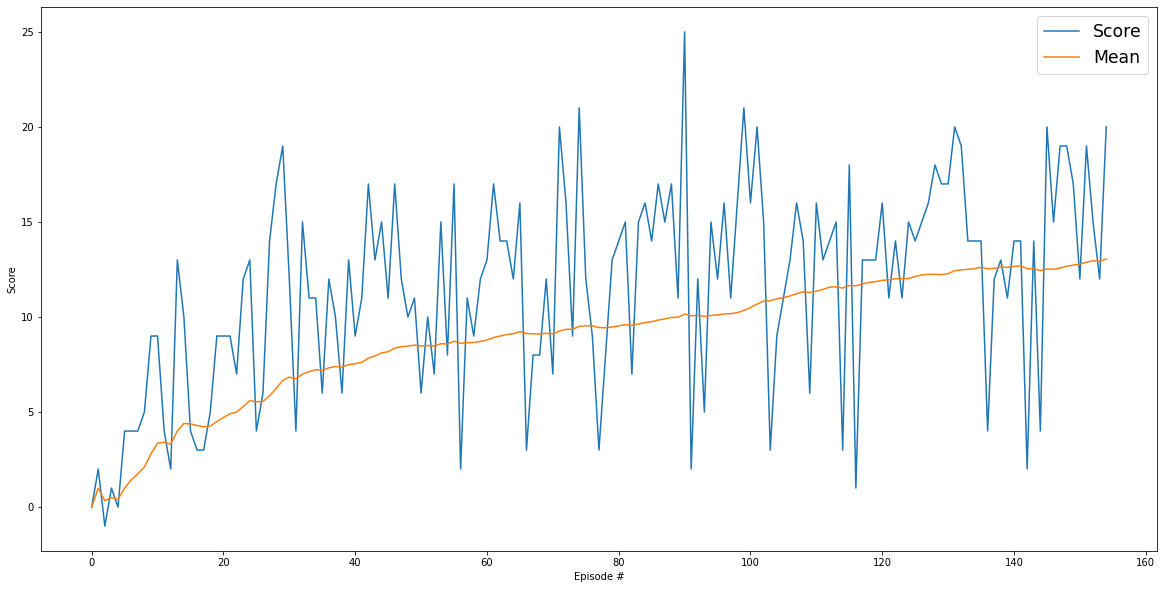

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
scores, mean = dqn(agent, n_episodes=200, max_t=300, eps_start=0.10, eps_end=0.01, eps_decay=0.98)
agent.save("checkpoint.pth")

# plot the scores
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(mean)), mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(('Score', 'Mean'), fontsize='xx-large')
plt.show()

### 6. Run Agent

In [3]:
# Create environment if it doesn't already exist
try:
    env
except:
    env = UnityEnvironment(environment_path)
    
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

agent = Agent(state_size=state_size, action_size=action_size, seed=0)
agent.load('checkpoint.pth')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Running on: cuda:0


In [5]:
episodes = 5 # number of episodes

## Train the Agent
scores = []       # list containing scores from each episode

for i_episode in range(1, episodes+1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state    
    score = 0    
    while True:
        action = agent.act(state)                      # get the next action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]  
        score += reward 
        state = next_state
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="")
        if done:
            break 

    scores.append(score)                               # save most recent score
    
    print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, scores[-1]))

Episode 1	Score: 13.00
Episode 2	Score: 0.00
Episode 3	Score: 16.00
Episode 4	Score: 11.00
Episode 5	Score: 9.000


# 7. Close the environment

In [10]:
env.close()